# Photometry

Photometry lab part  2:
This notebook is for the photometry part of the photometry lab. Data used is form the observing project. 

__Q8: What drawbacks could exist from this method of sky subtraction?__  
Aperture photometry forces you to draw a circle around an area that you assume most of the flux from your object falls within. This means that you miss some of the flux from your object distributed on the outsides of that circle. Aperture photometry is a biased and inconsistent estimator meaning that for an infinite number of observations, the flux measured asymptote to a value lower than the true value. These effects can be removed using aperture correction, or by using the same size aperature for calibration stars and science objects however this assumes that the PSF from these objects is the same.  

Estimating the background as the median of the entire image includes all of the science objects in the median. That means that the estimate is going to be larger than the true value of the sky background so that the flux is going to be smaller by some small amount. 

__Q9: Why does sky subtraction matter?__  

We have to subtract the sky because there is diffuse light coming from other objects that is incident on the entire CCD. This is a source of noise and therefore has to be removed from the calculation of the flux from the object of interest. 

In [2]:
import numpy as np
from photutils import datasets
from astropy.io import fits
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt


In [3]:
# Load in the data from one of the objects
images = glob.glob('data/CrabData/reduced/reduced2*.fits')

data = fits.getdata(images[5]).astype(float)

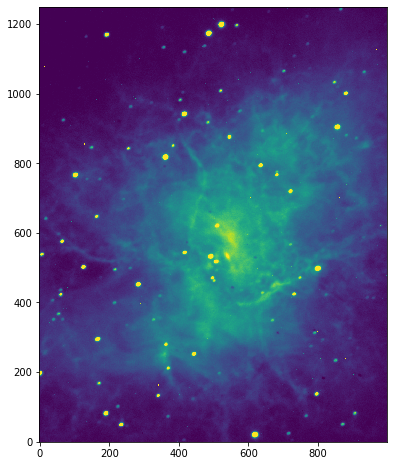

In [5]:
# Make a function to plot the image

def showImage(data, vMin = 5, vMax = 99.7):
    plt.figure(figsize = (8, 8))
    plt.imshow(data, vmin=np.percentile(data, vMin), vmax=np.percentile(data, vMax),
                origin='lower', cmap='viridis', interpolation='nearest')
showImage(data[500:1750, 500:1500])

In [6]:
# Do a really simple estimate of the background as the median of the image then subtract it.
data = data[500:1750, 500:1500]
appdata = data - np.median(data) # subtract the bkgrnd but only for the aperture phot estimate

In [7]:
# Imports for the actual photometry

from photutils import DAOStarFinder
from astropy.stats import mad_std

In [8]:
bkg_sigma = mad_std(appdata)  
daofind = DAOStarFinder(fwhm=8., threshold=3.*bkg_sigma)  
sources = daofind(appdata)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 619.14506  20.21511 0.32142759 ...   0 58265.191 37.580844  -3.9374163
  2 621.20145 21.309047 0.31737484 ...   0 58362.591 36.303238  -3.8998634
  3 717.07025 25.053934 0.35453335 ...   0 2161.7306 2.1435237 -0.82782073
  4 236.15391 50.425259 0.38524789 ...   0 18708.383 15.037669  -2.9429513
  5 872.57097 51.174302 0.35899152 ...   0 3330.5385  2.999882  -1.1927604
  6 370.80589 73.712845  0.2851324 ...   0 1468.8299 1.5629055 -0.48483182
  7 767.33217 75.662708 0.31638823 ...   0  1827.036 1.7923211 -0.63353953
  8 191.94031 82.491423 0.31188542 ...   0 32365.253 27.396297  -3.5942297
  9 907.42674 82.618478 0.29855693 ...   0 3556.5344  3.209981  -1.2662562
 10 226.38687 102.21312  0.3931393 ...   0 1876.8472  1.775613 -0.62337082
...       ...       ...        ... ... ...       ...       ...         ...
 70 521.74032 1009.0738 0

### What Happened?

The above is the result of usign DAOStarfinder to find all of the stars in the image flux that is 3 sigma where sigma. The above image assumes that the background has already been subtracted. Not really sure what the fwhm parameter is for.  

In the cells below I create circles surrounding each of the objects 

In [9]:
from photutils import aperture_photometry, CircularAperture 

In [10]:
# Getting rid of stars on the edges and on the overscan. 

# mask = sources['xcentroid'] > 10
# mask1 = sources['xcentroid'] < 2054
# mask3 = sources['xcentroid'] < 1020
# mask4 = sources['xcentroid'] > 1050
# biasMask = mask3 | mask4
# finalMask = mask & mask1 & biasMask

sources['xcentroid']

619.14506
621.20145
717.07025
236.15391
872.57097
370.80589
767.33217
191.94031
907.42674
226.38687
342.48183


In [11]:
ascii.write(sources, 'sources.csv', format = 'csv', fast_writer = False)


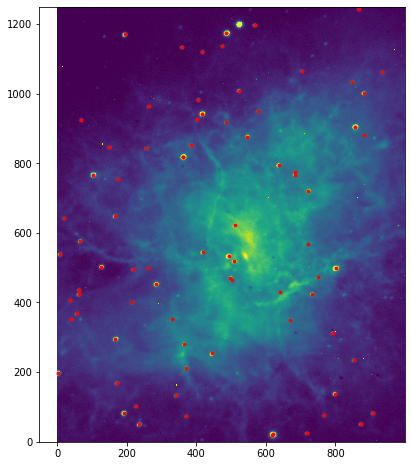

In [12]:
# Below I plot apertures surrounding each of the objects and estimate their flux using these circles
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  



 
showImage(appdata)
plt.scatter(positions[0:, 0], positions[0:, 1], marker = '.', color = 'r')

In [13]:

apertures = CircularAperture(positions, r=7.)  
phot_table = aperture_photometry(appdata, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  
ascii.write(phot_table, 'phot_values.csv', format='csv', fast_writer=False)  


 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 619.14506  20.21511    6296253.6
  2 621.20145 21.309047      6340958
  3 717.07025 25.053934    83933.248
  4 236.15391 50.425259    1089631.3
  5 872.57097 51.174302    163028.17
  6 370.80589 73.712845    65134.192
  7 767.33217 75.662708    86001.135
  8 191.94031 82.491423    2037341.7
  9 907.42674 82.618478    206404.97
 10 226.38687 102.21312    73179.025
...       ...       ...          ...
 71 848.88624  1033.779    273676.43
 72 934.42107 1063.1129    142785.25
 73 703.13092 1065.8874     165970.6
 74 417.74005 1121.0927    46590.439
 75 357.93867 1134.0729    63755.844
 76 475.57226 1138.3206    38549.589
 77 194.43866  1170.436    1190810.3
 78 486.95781 1174.0466    4982869.6
 79 567.86778 1197.1575    208662.73
 80 867.09947 1243.8652    75079.231
Length = 80 rows


In [14]:
appFluxs =  phot_table['aperture_sum']

__How many objects did you identify with DAOStarFinder? Look at your image.
Do you think that’s a reasonable number? What did you change to adjust the number of
stars detected? How many stars did you end up with?__

DOAStarFinder identified 116 objects using the bounds fwhm = 4 and sigma = 100* bkgd. Most of these objects were identified at the edges of the image and in the center where the overscan was before it was removed. That said, when creating a mask to remove these data is was necessary to trim a relatively large region ~10 pixels wide. I think 116 stars is somewhat large. This is especially because some of the obvious stars to the eye were left undected. To adjust the number of detected stars I increased the amount that that star had to deviate above the background in order to be counted. The first run of the function I used sigma = 3 and that returned ~600 stars. 

Doing this a second time having subtraceted more overscan fromt the fully reduced image causes DAOStarFinder to not get as many errors from the missed overscan pixels. There is some risk that I cut off some of dataful pixels in cutting a large region of overscan. 

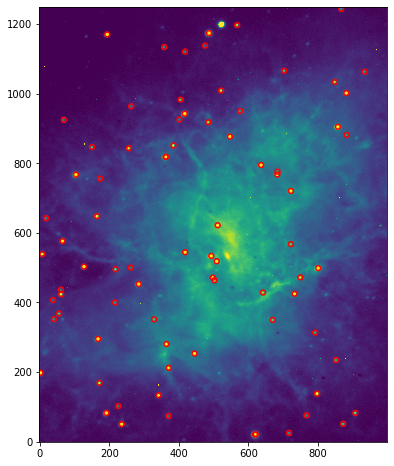

In [15]:
showImage(appdata)
apertures.plot(color='red', lw=1.5)
plt.savefig('circularapp.png')

__Are you happy with your apertures? Why or why not? Save the list of sources
for comparison. Why did you choose the method (center, exact, subpixel) to solve the
square pixel/round aperture problem?__

Yes these apertures seem ok. For some of the objects they may be too large however for most of the objects, r = 10 seems to be the appropriate radius. I chose to use the default method = exact to get the highest precision estimate within the given aperture I specified. 

In [16]:
from photutils import CircularAnnulus

In [17]:
apertures = CircularAnnulus(positions, r_in = 7, r_out = 14)  
phot_table = aperture_photometry(data, apertures)  #using bkgrnd subtracted data
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  
ascii.write(phot_table, 'phot_values.csv', format='csv', fast_writer=False)  

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 619.14506  20.21511    3166140.7
  2 621.20145 21.309047    3123289.8
  3 717.07025 25.053934      1815732
  4 236.15391 50.425259    1987973.8
  5 872.57097 51.174302    1820090.2
  6 370.80589 73.712845    1909173.1
  7 767.33217 75.662708    1891266.5
  8 191.94031 82.491423    2092099.7
  9 907.42674 82.618478      1877003
 10 226.38687 102.21312    1885918.8
...       ...       ...          ...
 71 848.88624  1033.779    2237491.1
 72 934.42107 1063.1129    2072367.2
 73 703.13092 1065.8874    1994122.7
 74 417.74005 1121.0927    1786588.5
 75 357.93867 1134.0729    1770691.2
 76 475.57226 1138.3206      1845330
 77 194.43866  1170.436    1860136.3
 78 486.95781 1174.0466    2438475.4
 79 567.86778 1197.1575      1804909
 80 867.09947 1243.8652    1256462.4
Length = 80 rows


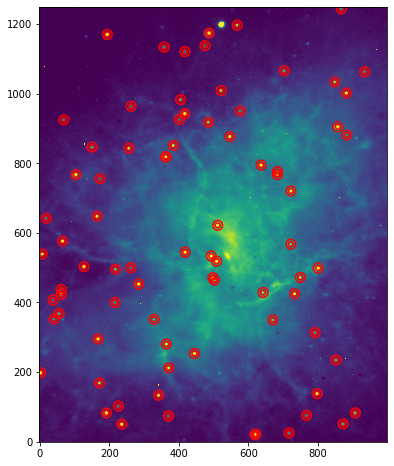

In [18]:
showImage(data)
apertures.plot(color='red', lw=1.5)

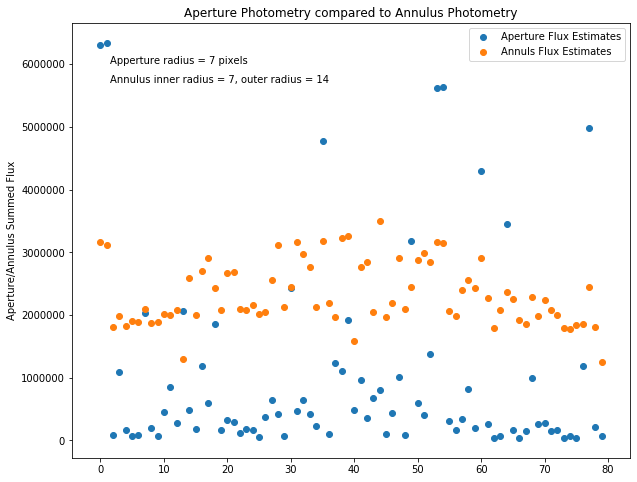

In [19]:
# Create a plot showing the difference between these two estimates of flux. 
x = np.arange(0, len(appFluxs), 1)

annFluxs = phot_table['aperture_sum']
plt.figure(figsize = (10, 8))
plt.scatter( x, appFluxs, label = 'Aperture Flux Estimates');
plt.scatter(x, annFluxs, label = 'Annuls Flux Estimates');
plt.title('Aperture Photometry compared to Annulus Photometry')
plt.legend()
plt.ylabel('Aperture/Annulus Summed Flux');

plt.text(1.5, 6000000, 'Apperture radius = 7 pixels')
plt.text(1.5, 5700000, 'Annulus inner radius = 7, outer radius = 14')
plt.savefig('appvsann.png')

In [20]:
diff = annFluxs - appFluxs
np.median(diff)

1806022.8952559303

Now using the unsubbed data for the PSF photometry

In [21]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

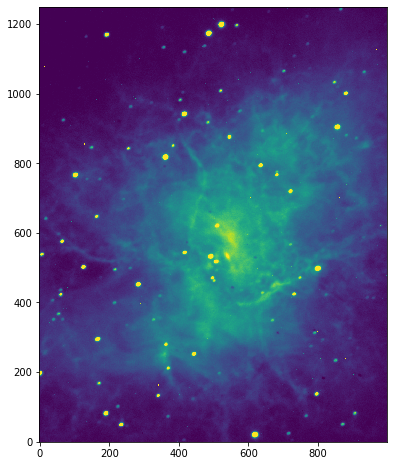

In [22]:
images = glob.glob('data/CrabData/reduced/reduced2*.fits')
data = fits.getdata(images[5]).astype(float)
image = data[500:1750, 500:1500] #changed to match code below
showImage(image)

In [23]:
sigma_psf = 2.0
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = DAOStarFinder(fwhm=8., threshold=3.*std)


daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

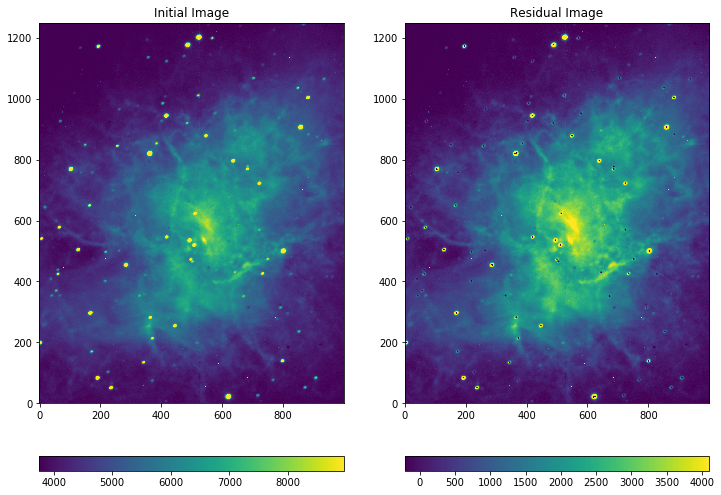

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize = (12, 24))
plt.subplot(1, 2, 1)

plt.imshow(image, vmin=np.percentile(image, 5), vmax=np.percentile(image, 99.7),
           origin = 'lower', cmap='viridis', aspect=1, interpolation='nearest',)

plt.title('Initial Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)

plt.imshow(residual_image, vmin=np.percentile(residual_image, 5), vmax=np.percentile(residual_image, 99.7), 
           origin = 'lower', cmap='viridis', aspect=1, interpolation='nearest',)
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()
plt.savefig('psfInitialandRes.png')

In [53]:
psfFlux = result_tab['flux_fit']

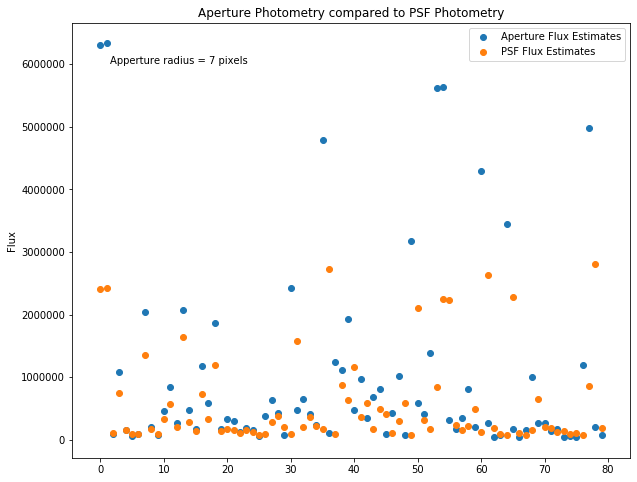

In [81]:
x = np.arange(0, len(annFluxs), 1)

annFluxs = phot_table['aperture_sum']
plt.figure(figsize = (10, 8))
plt.scatter( x, appFluxs, label = 'Aperture Flux Estimates');
plt.scatter(x, psfFlux[:-1], label = 'PSF Flux Estimates');
plt.title('Aperture Photometry compared to PSF Photometry')
plt.legend()
plt.ylabel('Flux');

plt.text(1.5, 6000000, 'Apperture radius = 7 pixels')

plt.savefig('appvspsf.png')

__Make a plot comparing the PSF fitting output to the aperture output. Are they
the same? Why or why not?__

No the same. The reason they aren't the same is because PSF photometry uses model fitting to estimate the flux of the star based on what the data value is. Somewhat like fitting a line to curve, the above model assumes that the light from every star is distributed as a gaussian around the center of the star with some known sigma. In this case I took sigma to be 2 pixels. Changing the value of sigma changes the result significantly. 

__(2 pt) Q14: What do you need to do differently for your science image? (For example - are
you studying one point source, many point sources, or a diffuse object? What does that
change?)__

For our science image, becasue we want to estimate the flux of the whole nebula, first use the PSF above to try and estimate the flux from the stars on top of that of the nebula. This will allow us to remove them from the estimate of the flux from the nebula alone. Because it is a diffuse source, I will need to use a different shape of aperture or add some other parameters to the PSF model inorder to reflect this change. 

__(2 pt) Q15: Did you prefer PSF fitting or aperture photometry? Think of one situation that
you think would be best for each method.__

I prefer aperture photometry. This I think this method gives a better estimate of the actual value of the flux by more effectively accounting for the background as well as accounting for the spread of the light across multiple pixels. Aperture photometry relies on estimating the spread of individual sources on the ccd which can introduce error.  
On situation where I think PSF photometry my be better is when there are multiple sources near each other. This suituation would not be very effective using aperture photometry as your regions would need to be very small to only inlcude a single source and as a result the aperture would likely miss some of the flux on the edges of the object.  
A situation where aperture photometry may be better is when there is an accurate accounting of the background nopise and prior knowledge of how spread out on the CCD the source is. In this case it is unecessary to use PSF photometry as the things for which it is advantageous have already been accounted for. 